In [40]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
ndevice = 4
#os.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=4"

import numpyro
numpyro.set_host_device_count(ndevice)
import matplotlib.pyplot as plt
import arviz as az
from astropy.cosmology import Planck18
import astropy.units as u
import sys
sys.path.append('../src/scripts/')
import intensity_models
import jax
import numpy as np
from numpyro.infer import MCMC, NUTS, SA
import os.path as op
import pandas as pd
import paths
from utils import get_priors_from_file
from importlib import reload
import corner
import seaborn as sns
from intensity_models import coords
import scipy.stats as ss
from importlib import reload
reload(intensity_models)

<module 'intensity_models' from '/Users/abbymoran/PPISNBump/reproduce/../src/scripts/intensity_models.py'>

In [45]:
numpyro.set_host_device_count(4)

In [46]:
print("Device count:", jax.local_device_count())

Device count: 1


In [31]:
import gc
gc.collect()
# https://iopscience.iop.org/article/10.3847/1538-4357/ad8572

6634

In [33]:
nmcmc = 750 #1000
nchain = 4
random_seed = 1652819403

In [34]:
prior = get_priors_from_file("gwtc3_evolution.prior")

pe_samples = pd.read_hdf('pe_samples.h5', 'samples')
pe_samples['pdraw_cosmo']=pe_samples['prior_m1d_q_dL']

sel_samples = pd.read_hdf('selection_samples.h5', 'samples')
sel_samples['pdraw_cosmo'] = sel_samples['pdraw_m1sqz']*sel_samples['dm1sz_dm1ddl']
sel_samples['m1d'] = sel_samples['m1']*(1+sel_samples['z'])
sel_samples['dl'] = Planck18.luminosity_distance(sel_samples['z'].to_numpy()).to(u.Gpc).value

evts = pe_samples.groupby('evt')
m1s = []
qs = []
dls = []
pdraws = []
for (n, e) in evts:
    m1s.append(e['mass_1'])
    qs.append(e['mass_ratio'])
    dls.append(e['luminosity_distance_Gpc'])
    pdraws.append(e['pdraw_cosmo'])

m1s, qs, dls, pdraws = map(np.array, [m1s, qs, dls, pdraws])
print("array shapes (we want nevents, nsamples): ", m1s.shape, qs.shape, dls.shape, pdraws.shape)

array shapes (we want nevents, nsamples):  (58, 3000) (58, 3000) (58, 3000) (58, 3000)


### Fixed "correct" cosmology

In [47]:
import subprocess

nchain = 4
procs = []

for i in range(nchain):
    log_file = open(f"chain_{i}.log", "w")
    proc = subprocess.Popen(["python", "run_chain.py", str(i)],
                            stdout=log_file,
                            stderr=subprocess.STDOUT)  # combine stdout + stderr
    procs.append((proc, log_file))

# Wait for all chains to finish and close log files
for proc, log_file in procs:
    proc.wait()
    log_file.close()

print("All chains finished")


KeyboardInterrupt



In [44]:
ndraw = float(sel_samples['ndraw'][0])
    
kernel = NUTS(intensity_models.pop_cosmo_model)
mcmc =MCMC(kernel, num_warmup=nmcmc, num_samples=nmcmc, num_chains=nchain, chain_method="parallel")
mcmc.run(jax.random.PRNGKey(random_seed),
         m1s, qs, dls, pdraws,
         np.asarray(sel_samples['m1d']), np.asarray(sel_samples['q']), np.asarray(sel_samples['dl']), 
         np.asarray(sel_samples['pdraw_cosmo']), ndraw, prior)
trace = az.from_numpyro(mcmc)
az.to_netcdf(trace, 'trace_evolution_nocosmo.nc')
#print(mcmc.get_samples().keys())


/var/folders/bw/0h0f_0zs4z195525560spdjm0000gn/T/ipykernel_90494/537707929.py:4: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc =MCMC(kernel, num_warmup=nmcmc, num_samples=nmcmc, num_chains=nchain, chain_method="parallel")
warmup:   0%|               | 3/1500 [00:30<4:17:14, 10.31s/it, 3 steps of size 1.67e-02. acc. prob=0.00]


KeyboardInterrupt: 

In [27]:
reload(intensity_models2)


<module 'intensity_models2' from '/Users/abbymoran/PPISNBump/reproduce/../src/scripts/intensity_models2.py'>

In [28]:
ndraw = float(sel_samples['ndraw'][0])
    
kernel = NUTS(intensity_models2.pop_cosmo_model)
mcmc =MCMC(kernel, num_warmup=nmcmc, num_samples=nmcmc, num_chains=nchain, chain_method="parallel")
mcmc.run(jax.random.PRNGKey(random_seed),
         m1s, qs, dls, pdraws,
         np.asarray(sel_samples['m1d']), np.asarray(sel_samples['q']), np.asarray(sel_samples['dl']), 
         np.asarray(sel_samples['pdraw_cosmo']), ndraw, prior)
trace = az.from_numpyro(mcmc)
az.to_netcdf(trace, 'trace_evolution_nocosmo.nc')
#print(mcmc.get_samples().keys())


mpisn (Array(30, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True))
mco (Array(1, dtype=int32, weak_type=True), Array(1800, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True))


ValueError: xp and fp must be one-dimensional arrays of equal size

array([[<Axes: title={'center': 'R'}>, <Axes: title={'center': 'R'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'mpisn'}>,
        <Axes: title={'center': 'mpisn'}>],
       [<Axes: title={'center': 'mbhmax'}>,
        <Axes: title={'center': 'mbhmax'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'fpl'}>, <Axes: title={'center': 'fpl'}>],
       [<Axes: title={'center': 'lam'}>, <Axes: title={'center': 'lam'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>],
       [<Axes: title={'center': 'zp'}>, <Axes: title={'center': 'zp'}>],
       [<Axes: title={'center': 'neff'}>,
        <Axes: t

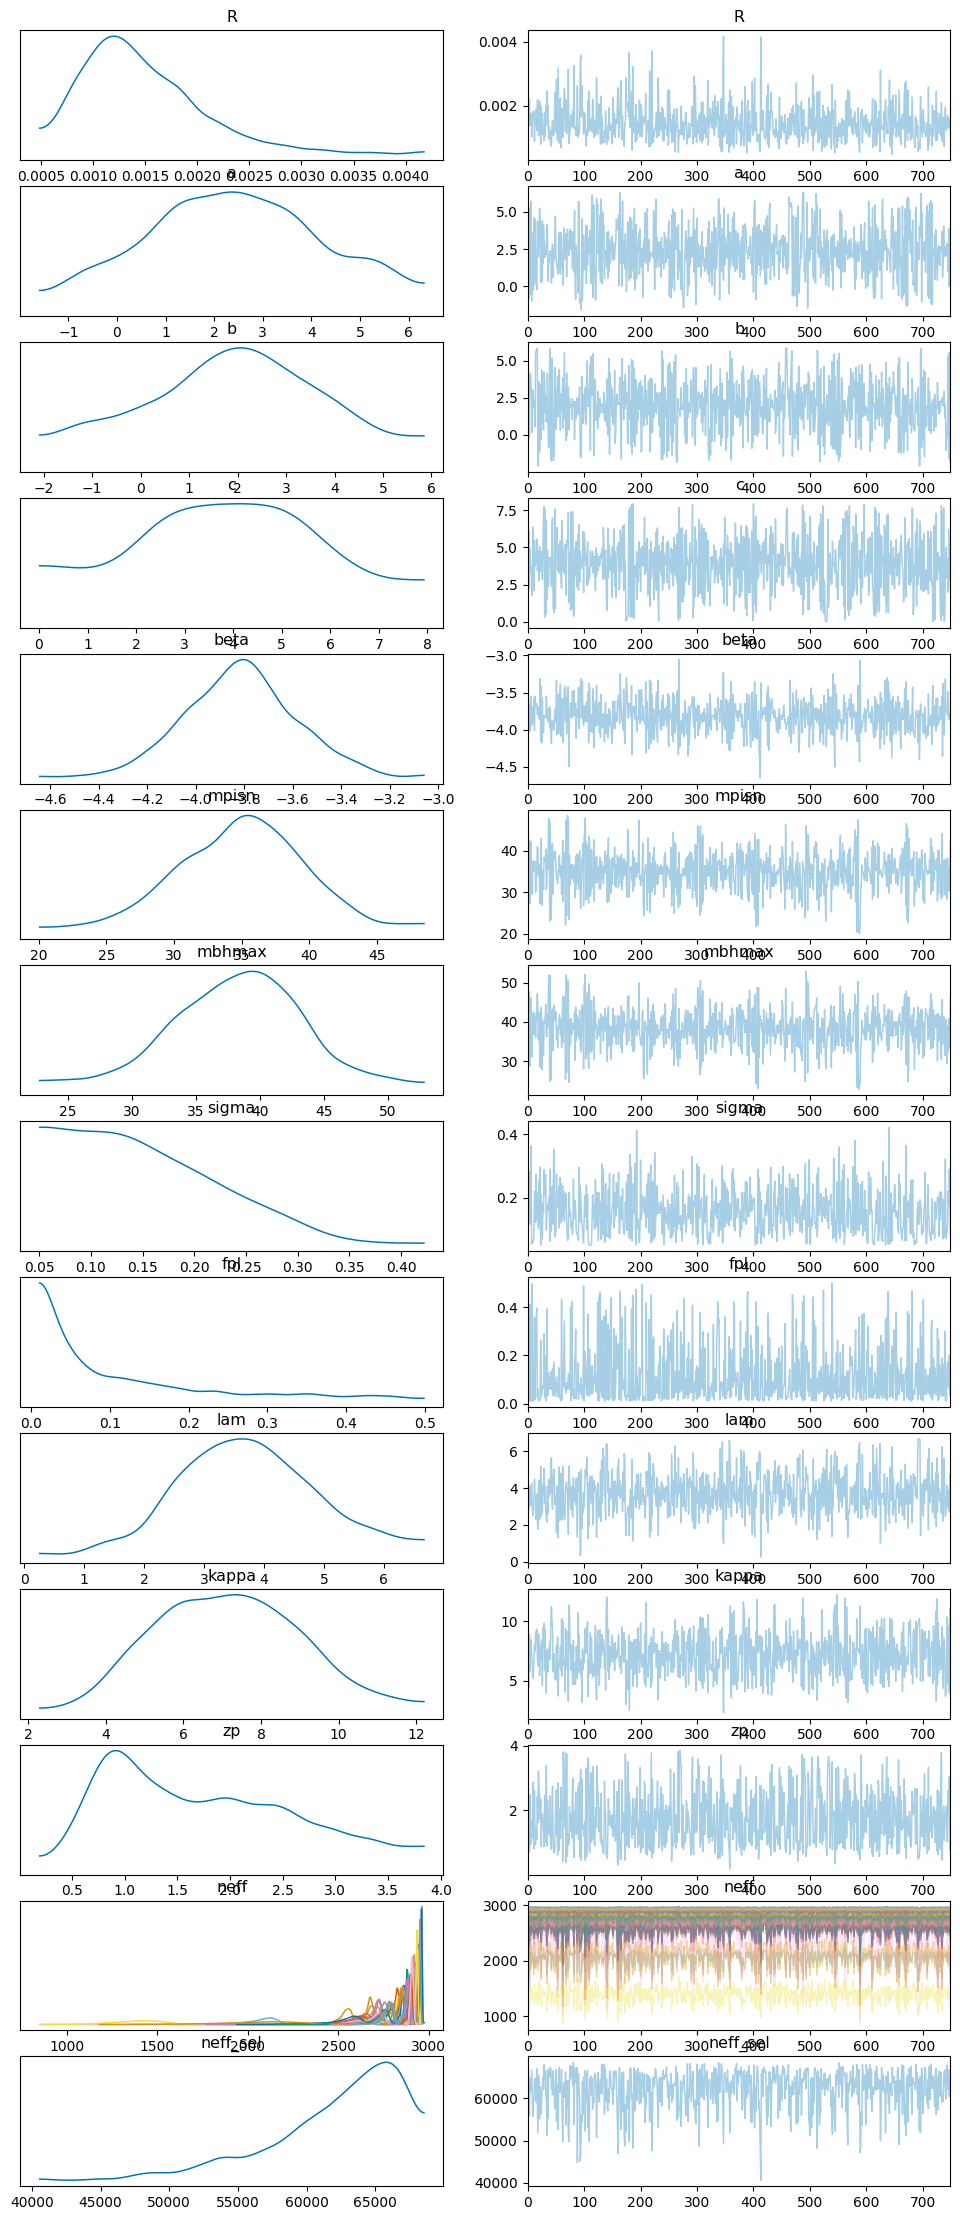

In [73]:
trace = az.from_netcdf(op.join(paths.data, '../../reproduce/trace_evolution_nocosmo.nc'))
az.plot_trace(trace, var_names=['R', 'a', 'b', 'c', 'beta', 'mpisn', 'mbhmax', 'sigma', 'fpl', 'lam', 'kappa', 'zp', 'neff', 'neff_sel'])

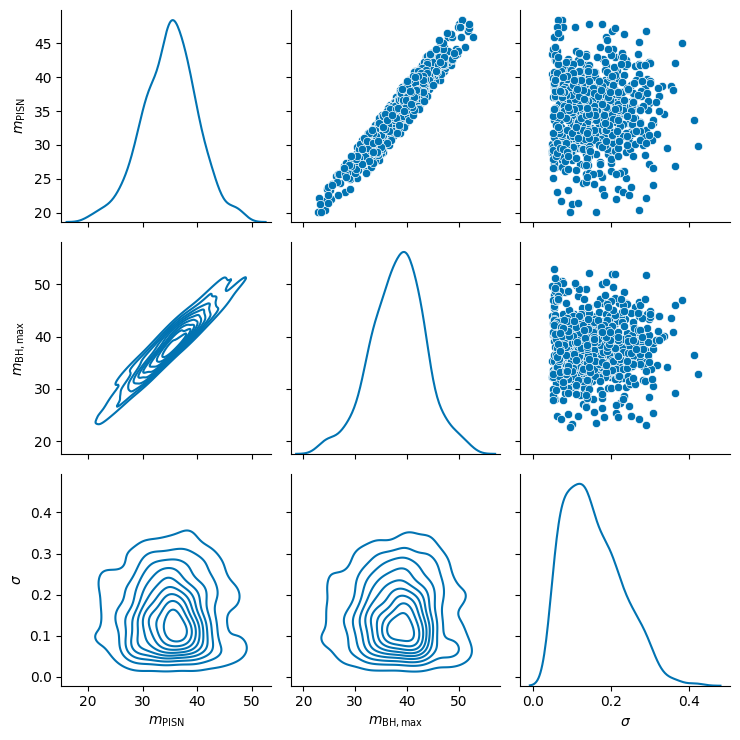

In [66]:
sns.set_palette('colorblind')
#trace = az.from_netcdf(op.join(paths.data, 'trace.nc'))

axes_labels = {
    'mpisn': r'$m_\mathrm{PISN}$',
    'mbhmax': r'$m_\mathrm{BH,max}$',
    'sigma': r'$\sigma$'
}
df = pd.DataFrame({axes_labels[k]: trace.posterior[k].values.flatten() for k in axes_labels.keys()})

pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

plt.tight_layout()
plt.savefig(op.join(paths.figures, 'shape_corner.pdf'))

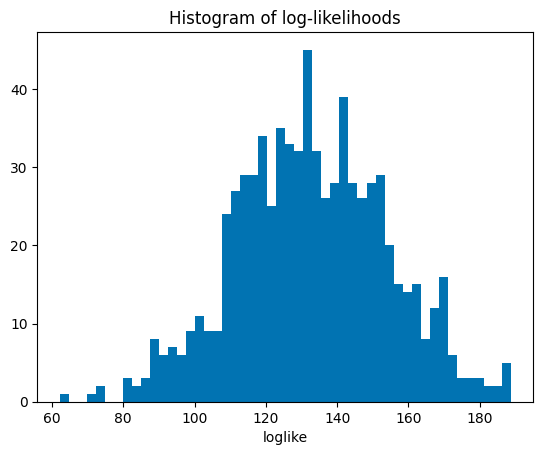

<xarray.DataArray 'loglike' ()> Size: 4B
array(132.78001, dtype=float32)
<xarray.DataArray 'loglike' ()> Size: 4B
array(21.303598, dtype=float32)


In [67]:
trace = az.from_netcdf(op.join(paths.data, '../../reproduce/trace_evolution_nocosmo.nc'))

loglike=trace.log_likelihood["loglike"]
loglike.stack(sample=("chain", "draw")).plot.hist(bins=50)
plt.title("Histogram of log-likelihoods")
plt.show()
print(loglike.mean(dim=("chain", "draw")))
print(loglike.std(dim=("chain", "draw")))

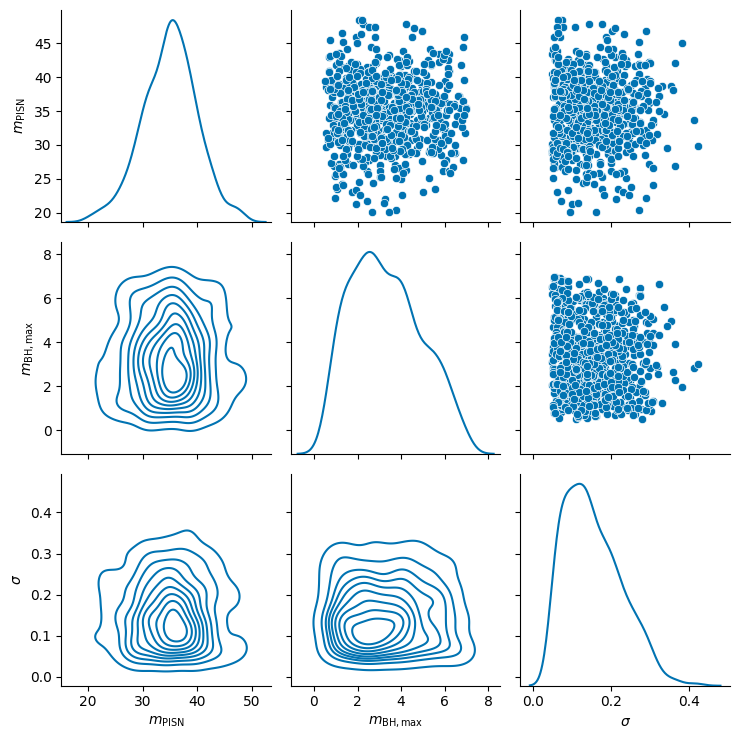

In [68]:
sns.set_palette('colorblind')
#trace = az.from_netcdf(op.join(paths.data, 'trace.nc'))

axes_labels = {
    'mpisn': r'$m_\mathrm{PISN}$',
    'dmbhmax': r'$m_\mathrm{BH,max}$',
    'sigma': r'$\sigma$'
}
df = pd.DataFrame({axes_labels[k]: trace.posterior[k].values.flatten() for k in axes_labels.keys()})

pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

plt.tight_layout()
plt.savefig(op.join(paths.figures, 'shape_corner.pdf'))

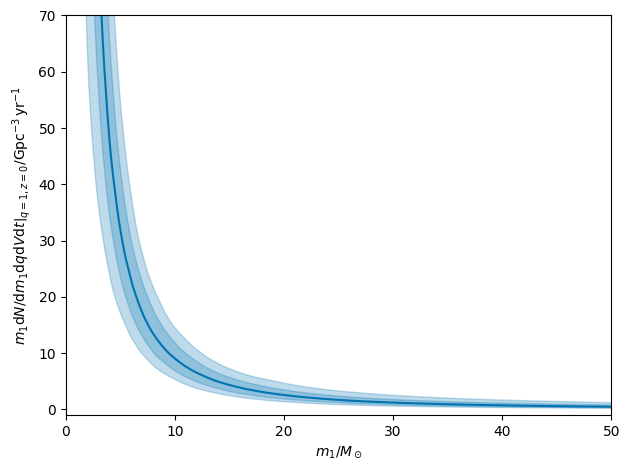

In [71]:
sns.set_palette('colorblind')

d = ['chain', 'draw']
dN = trace.posterior.mdNdmdVdt_fixed_qz 
m = dN.median(dim=d)
l = dN.quantile(0.16, dim=d)
h = dN.quantile(0.84, dim=d)
ll = dN.quantile(0.025, dim=d)
hh = dN.quantile(0.975, dim=d)

x = coords['m_grid']

line, = plt.plot(x[1:], m[1:])
plt.fill_between(x[1:], h[1:], l[1:], color=line.get_color(), alpha=0.25)
plt.fill_between(x[1:], hh[1:], ll[1:], color=line.get_color(), alpha=0.25)


plt.xlabel(r'$m_1 / M_\odot$')
plt.ylabel(r'$\left. m_1 \mathrm{d}N/\mathrm{d}m_1 \mathrm{d} q \mathrm{d} V \mathrm{d} t \right|_{q=1,z=0} / \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}$')

#plt.xscale('log')
#plt.yscale('log')
plt.xlim(0, 50)
plt.ylim(-1,70)
plt.tight_layout()
plt.savefig(op.join(paths.figures, 'dNdm_fitted.pdf'))

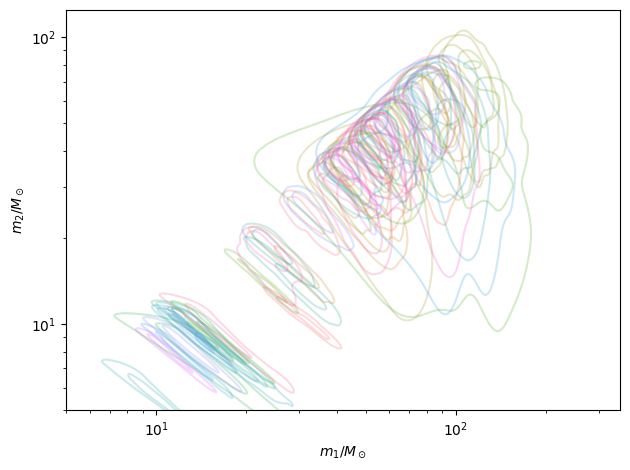

In [72]:
samples = pd.read_hdf('pe_samples.h5', 'samples')

events = samples.groupby('evt')

with sns.color_palette('husl', n_colors=len(events)):
    for evt, samps in events:
        m2 = samps['mass_1']*samps['mass_ratio']
        sns.kdeplot(x=samps['mass_1'], y=m2, levels=[0.1, 0.5], alpha=0.25)
    
    plt.xlabel(r'$m_1 / M_\odot$')
    plt.ylabel(r'$m_2 / M_\odot$')

    plt.xscale('log')
    plt.yscale('log')

    plt.xlim(5)
    plt.ylim(5)

    plt.tight_layout()
    plt.savefig(op.join(paths.figures, 'm1-vs-m2.pdf'))

/Users/abbymoran/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1513: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=vector, **plot_kwargs)
/Users/abbymoran/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1513: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=vector, **plot_kwargs)
/Users/abbymoran/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1513: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=vector, **plot_kwargs)
/Users/abbymoran/opt/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/Users/abbymoran/opt/anaconda3/lib/python3.11/site-packages/

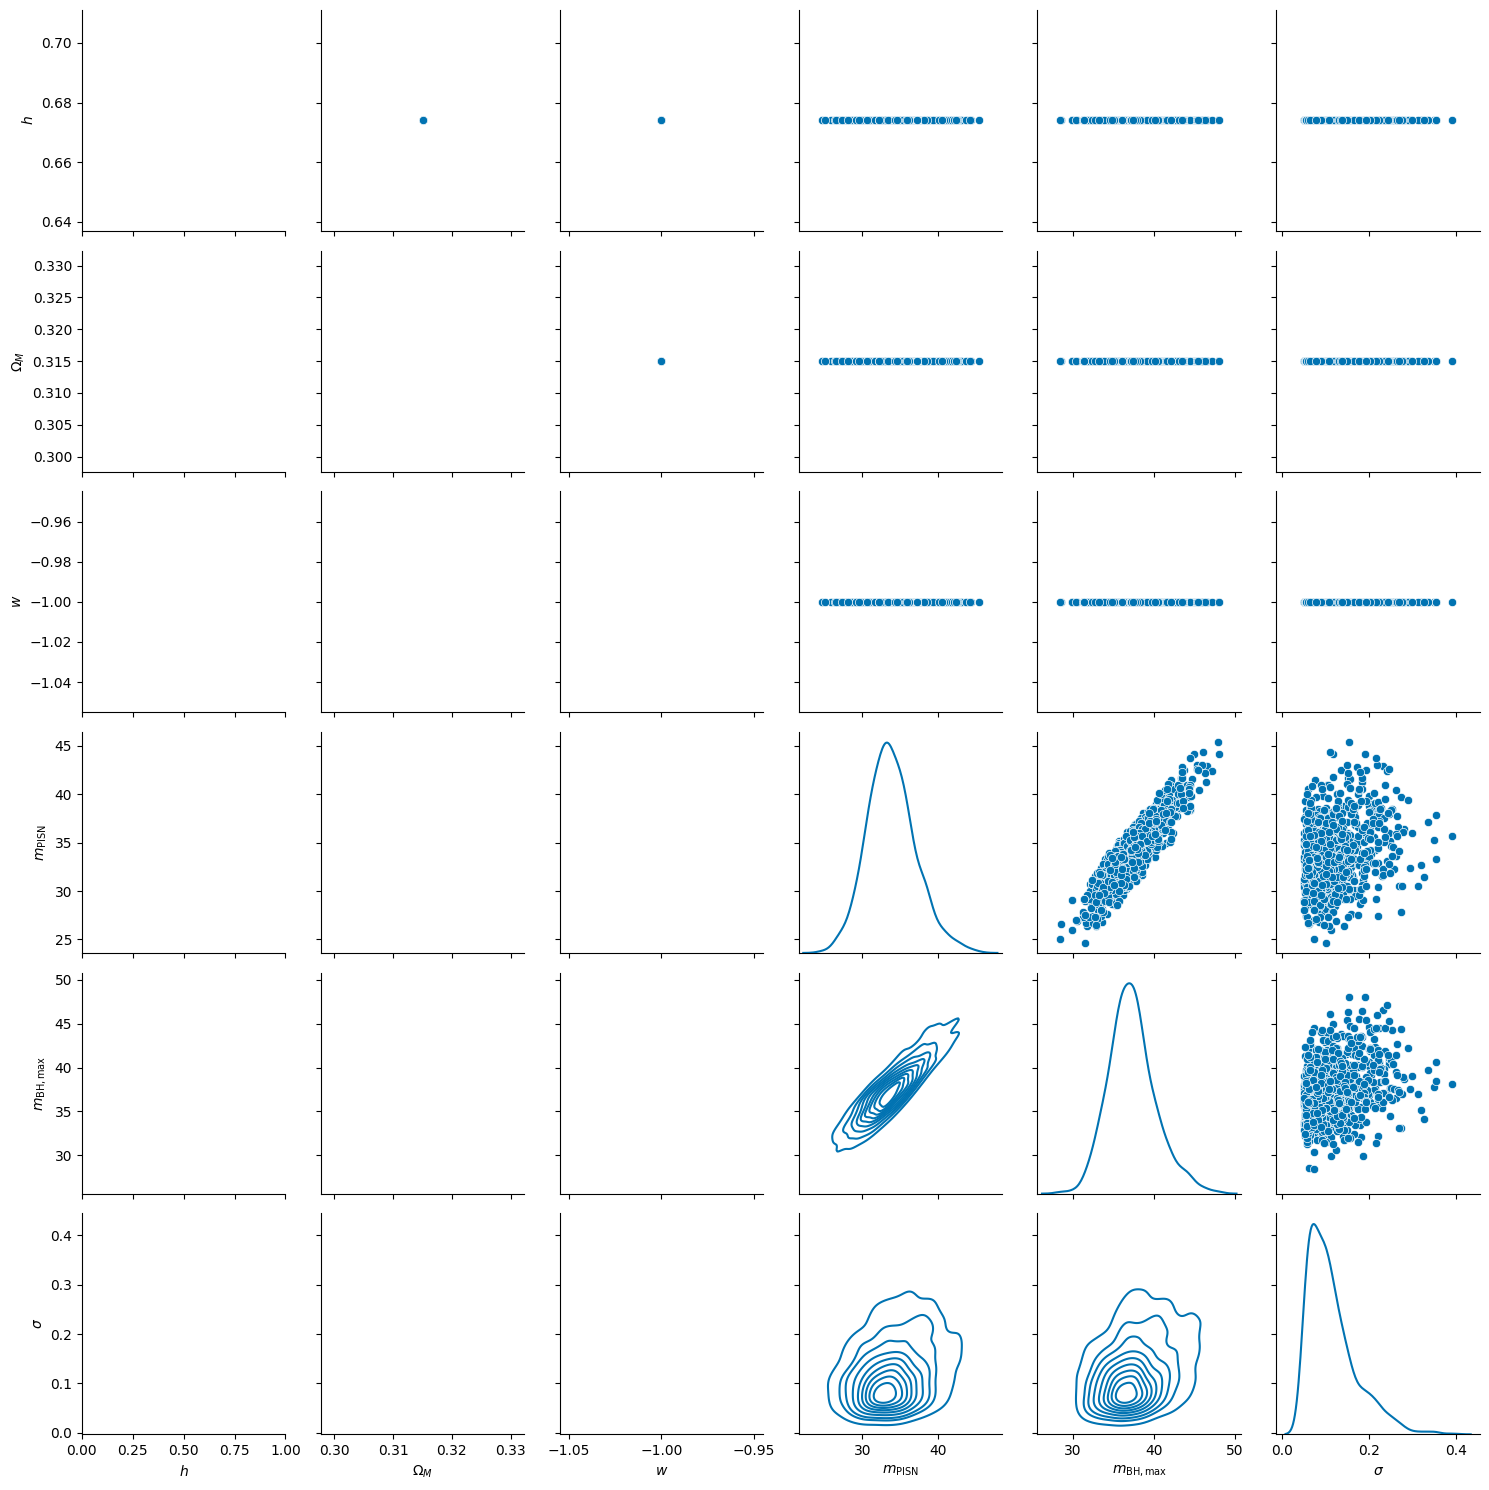

In [32]:
axes_labels = {'h': r'$h$', 
               'Om': r'$\Omega_M$',
               'w': r'$w$',
               'mpisn': r'$m_\mathrm{PISN}$',
               'mbhmax': r'$m_\mathrm{BH,max}$',
               'sigma': r'$\sigma$'}
df = pd.DataFrame({axes_labels[k]: trace.posterior[k].values.flatten() for k in axes_labels.keys()})

pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

plt.tight_layout()
plt.savefig(op.join(paths.figures, 'cosmo_params_corner.pdf'))

In [8]:
trace = az.from_netcdf(op.join(paths.data, '../../reproduce/trace_evolution_nocosmo.nc'))


array([[<Axes: title={'center': 'mpisndot'}>,
        <Axes: title={'center': 'mpisndot'}>]], dtype=object)

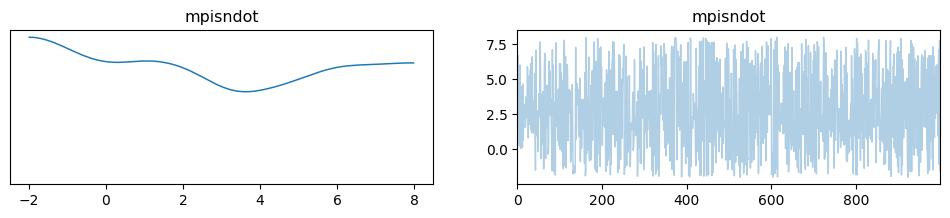

In [19]:
az.plot_trace(trace, var_names=['mpisndot'])

### Fixed "wrong" cosmology

In [ ]:
# mess around with the Hubble constant

In [21]:
prior = get_priors_from_file("gwtc3_evolution-badcosmo.prior")

pe_samples = pd.read_hdf('pe_samples.h5', 'samples')
pe_samples['pdraw_cosmo']=pe_samples['prior_m1d_q_dL']

sel_samples = pd.read_hdf('selection_samples.h5', 'samples')
sel_samples['pdraw_cosmo'] = sel_samples['pdraw_m1sqz']*sel_samples['dm1sz_dm1ddl']
sel_samples['m1d'] = sel_samples['m1']*(1+sel_samples['z'])
sel_samples['dl'] = Planck18.luminosity_distance(sel_samples['z'].to_numpy()).to(u.Gpc).value

evts = pe_samples.groupby('evt')
m1s = []
qs = []
dls = []
pdraws = []
for (n, e) in evts:
    m1s.append(e['mass_1'])
    qs.append(e['mass_ratio'])
    dls.append(e['luminosity_distance_Gpc'])
    pdraws.append(e['pdraw_cosmo'])

m1s, qs, dls, pdraws = map(np.array, [m1s, qs, dls, pdraws])
print("array shapes (we want nevents, nsamples): ", m1s.shape, qs.shape, dls.shape, pdraws.shape)

array shapes (we want nevents, nsamples):  (59, 1000) (59, 1000) (59, 1000) (59, 1000)


In [ ]:
ndraw = float(sel_samples['ndraw'][0])
    
kernel = NUTS(intensity_models.pop_cosmo_model)
mcmc = MCMC(kernel, num_warmup=nmcmc, num_samples=nmcmc, num_chains=nchain)
mcmc.run(jax.random.PRNGKey(random_seed),
         m1s, qs, dls, pdraws,
         sel_samples['m1d'], sel_samples['q'], sel_samples['dl'], sel_samples['pdraw_cosmo'], ndraw, prior)
loglike = mcmc.get_extra_fields(group_by_chain=True)["loglike"]  # shape: (chain, draw, nobs)
idata = az.from_numpyro(mcmc, log_likelihood={"loglike": loglike})
#trace = az.from_numpyro(mcmc)
az.to_netcdf(idata, "trace_evolution_nocosmo.nc")
#az.to_netcdf(trace, 'trace_evolution_nocosmo.nc')

In [23]:
ndraw = float(sel_samples['ndraw'][0])
    
kernel = NUTS(intensity_models.pop_cosmo_model)
mcmc = MCMC(kernel, num_warmup=nmcmc, num_samples=nmcmc, num_chains=nchain)
mcmc.run(jax.random.PRNGKey(random_seed),
         m1s, qs, dls, pdraws,
         sel_samples['m1d'], sel_samples['q'], sel_samples['dl'], sel_samples['pdraw_cosmo'], ndraw, prior)
loglike = mcmc.get_extra_fields(group_by_chain=True)["loglike"]  # shape: (chain, draw, nobs)
idata = az.from_numpyro(mcmc, log_likelihood={"loglike": loglike})
az.to_netcdf(idata, "trace_evolution_badcosmo.nc")

#trace = az.from_numpyro(mcmc)
#az.to_netcdf(trace, 'trace_evolution_badcosmo.nc')

sample: 100%|██| 2000/2000 [25:39:45<00:00, 46.19s/it, 31 steps of size 1.24e-01. acc. prob=0.93]


'trace_evolution_badcosmo.nc'

array([[<Axes: title={'center': 'R'}>, <Axes: title={'center': 'R'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'mpisn'}>,
        <Axes: title={'center': 'mpisn'}>],
       [<Axes: title={'center': 'mbhmax'}>,
        <Axes: title={'center': 'mbhmax'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'fpl'}>, <Axes: title={'center': 'fpl'}>],
       [<Axes: title={'center': 'lam'}>, <Axes: title={'center': 'lam'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>],
       [<Axes: title={'center': 'zp'}>, <Axes: title={'center': 'zp'}>],
       [<Axes: title={'center': 'neff'}>,
        <Axes: t

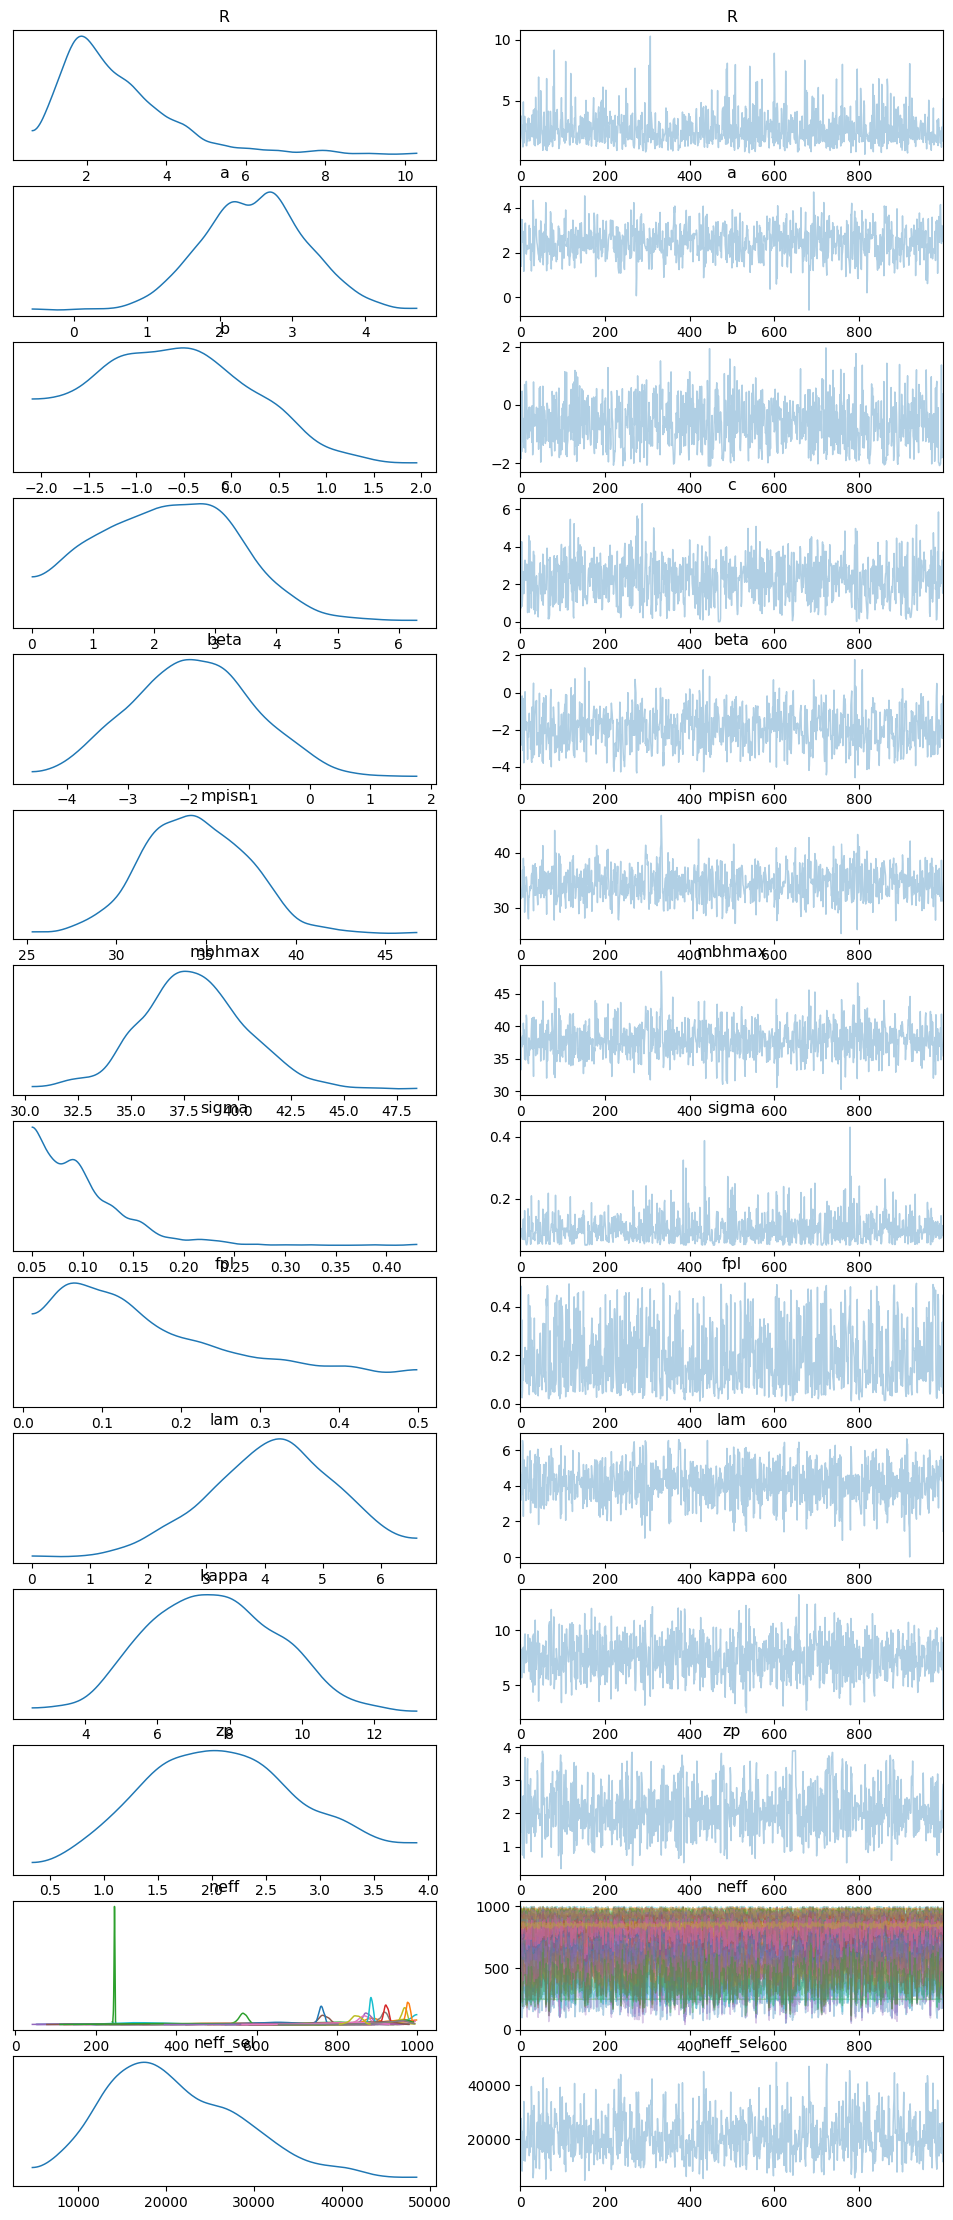

In [34]:
trace = az.from_netcdf(op.join(paths.data, '../../reproduce/trace_evolution_badcosmo.nc'))
az.plot_trace(trace, var_names=['R', 'a', 'b', 'c', 'beta', 'mpisn', 'mbhmax', 'sigma', 'fpl', 'lam', 'kappa', 'zp', 'neff', 'neff_sel'])

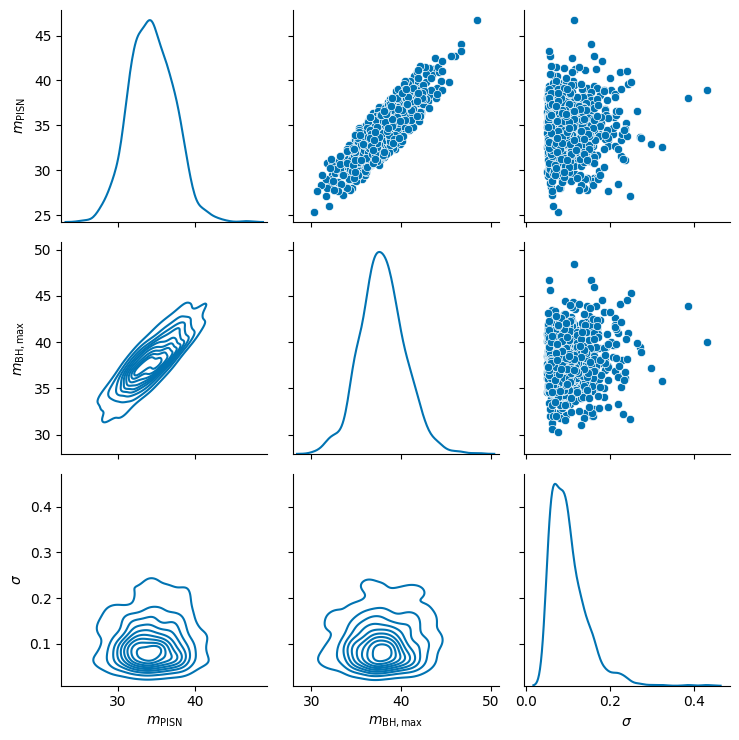

In [25]:
sns.set_palette('colorblind')
#trace = az.from_netcdf(op.join(paths.data, 'trace.nc'))

axes_labels = {
    'mpisn': r'$m_\mathrm{PISN}$',
    'mbhmax': r'$m_\mathrm{BH,max}$',
    'sigma': r'$\sigma$'
}
df = pd.DataFrame({axes_labels[k]: trace.posterior[k].values.flatten() for k in axes_labels.keys()})

pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

plt.tight_layout()
#plt.savefig(op.join(paths.figures, 'shape_corner.pdf'))

array([[<Axes: title={'center': 'mpisndot'}>,
        <Axes: title={'center': 'mpisndot'}>]], dtype=object)

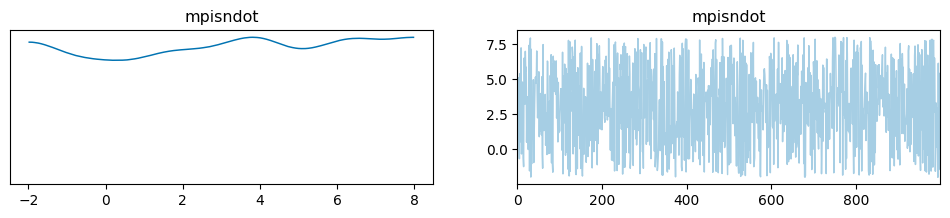

In [26]:
az.plot_trace(trace, var_names=['mpisndot'])

In [28]:
az.rhat(trace)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


<xarray.Dataset> Size: 9kB
Dimensions:                   (dNdVdt_fixed_mq_dim_0: 128,
                               dNdqdVdt_fixed_mz_dim_0: 128, hz_dim_0: 128,
                               mdNdmdVdt_fixed_qz_dim_0: 128, neff_dim_0: 59)
Coordinates:
  * dNdVdt_fixed_mq_dim_0     (dNdVdt_fixed_mq_dim_0) int64 1kB 0 1 ... 126 127
  * dNdqdVdt_fixed_mz_dim_0   (dNdqdVdt_fixed_mz_dim_0) int64 1kB 0 1 ... 127
  * hz_dim_0                  (hz_dim_0) int64 1kB 0 1 2 3 4 ... 124 125 126 127
  * mdNdmdVdt_fixed_qz_dim_0  (mdNdmdVdt_fixed_qz_dim_0) int64 1kB 0 1 ... 127
  * neff_dim_0                (neff_dim_0) int64 472B 0 1 2 3 4 ... 55 56 57 58
Data variables: (12/29)
    Om                        float64 8B nan
    R                         float64 8B nan
    R_unit                    float64 8B nan
    a                         float64 8B nan
    b                         float64 8B nan
    beta                      float64 8B nan
    ...                        ...
    neff                      (neff_dim_0) float64 472B nan nan nan ... nan nan
    neff_sel                  float64 8B nan
    sigma                     float64 8B nan
    w                         float64 8B nan
    zmax                      float64 8B nan
    zp                        float64 8B nan

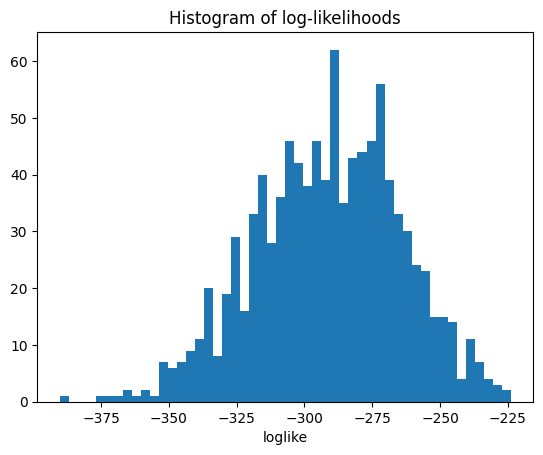

<xarray.DataArray 'loglike' ()> Size: 4B
array(-291.3203, dtype=float32)
<xarray.DataArray 'loglike' ()> Size: 4B
array(27.019276, dtype=float32)


In [39]:
trace = az.from_netcdf(op.join(paths.data, '../../reproduce/trace_evolution_badcosmo.nc'))
loglike=trace.log_likelihood["loglike"]
loglike.stack(sample=("chain", "draw")).plot.hist(bins=50)
plt.title("Histogram of log-likelihoods")
plt.show()
print(loglike.mean(dim=("chain", "draw")))
print(loglike.std(dim=("chain", "draw")))
# higher is better, so normal cosmo is doing better

In [53]:
data=az.from_netcdf('trace_evolution_nocosmo.nc')
data_2=az.from_netcdf('trace_evolution_badcosmo.nc')

In [54]:
print("Bad cosmo: ", az.loo(data_2, var_name='loglike'))
print("Normal cosmo: ", az.loo(data, var_name='loglike'))

# lower is better, nomral cosmo is doing better

Bad cosmo:  Computed from 1000 posterior samples and 1.0 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -371.14     0.00
p_loo      140.39        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.67]   (good)        0    0.0%
   (0.67, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    1  100.0%

Normal cosmo:  Computed from 1000 posterior samples and 1.0 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -372.64     0.00
p_loo      169.28        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.67]   (good)        0    0.0%
   (0.67, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    1  100.0%



/Users/abbymoran/opt/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/abbymoran/opt/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:840: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  warnings.warn(
/Users/abbymoran/opt/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importan

In [52]:
print("Bad cosmo: ", az.waic(data_2, var_name='loglike'))
print("Normal cosmo: ", az.waic(data, var_name='loglike'))

# lower is better, normal hubble constant is doing better

Bad cosmo:  Computed from 1000 posterior samples and 1.0 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -960.79     0.00
p_waic      730.04        -

There has been a warning during the calculation. Please check the results.
Normal cosmo:  Computed from 1000 posterior samples and 1.0 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1013.20     0.00
p_waic      809.84        -

There has been a warning during the calculation. Please check the results.


/Users/abbymoran/opt/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/abbymoran/opt/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1683: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  warnings.warn(
/Users/abbymoran/opt/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/abbymoran/opt/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1683: UserWarni

In [67]:
trace_bc = az.from_netcdf(op.join(paths.data, '../../reproduce/trace_evolution_badcosmo.nc'))
trace_c = az.from_netcdf(op.join(paths.data, '../../reproduce/trace_evolution_nocosmo.nc'))
az.compare({"No cosmo": trace_c, "Bad cosmo": trace_bc}, ic='loo',  var_name='loglike')


/Users/abbymoran/opt/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/abbymoran/opt/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:840: UserWarning: The point-wise LOO is the same with the sum LOO, please double check the Observed RV in your model to make sure it returns element-wise logp.
  warnings.warn(
/Users/abbymoran/opt/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.67 for one or more samples. You should consider using a more robust model, this is because importan

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Bad cosmo,0,-371.144958,140.394608,0.000000,1.0,0.0,0.0,True,log
No cosmo,1,-372.637390,169.283234,1.492432,0.0,0.0,0.0,True,log


In [65]:
loglike.shape

(1, 1000)